# 2024 Winter Introduction to Deep Learning
### Based on Prof. Oh's Youtube Lecture
https://youtube.com/playlist?list=PLvbUC2Zh5oJvByu9KL82bswYT2IKf0K1M

> Assignment #6


*   Youtube Lecture #23-26
*   Written by Seungeun Lee

## 2. Multi-class Classification w/ pre-trained ResNet model
*     Dataset: CIFAR10



*    Reference. https://github.com/Justin-A/DeepLearning101/blob/master/4-5_Load-Pre-trained_Model.ipynb

### Quick Question. This chapter covers concepts and applications of Transfer Learning. Then what's the transfer learning? Google it and write your own answer.

###  전이학습(Transfer Learning) 이란 사전 학습된 모델을 새로운 작업에 맞춰 미세 조정(fine tuning)하는 학습 기법이다.

### 전이학습을 하기 위해서는 여러 가지 고려해야 할 사항이 크게 두가지가 있다.
#### 먼저, 사전에 학습된 모델을 학습하는 데에 사용한 데이터와 우리가 새롭게 전이학습을 하기 위해 사용하려는 데이터 사이의 유사도와 새롭게 전이학습을 하기 위해 사용하려는 데이터 셋의 크기가 있다.

1.   매우 작은 데이터 셋의 크기, 유사한 데이터 셋 : 미세 조정을 하기 위해서 끝 부분의 레이어만 수정해주어 학습을 하면 된다.
2.   매우 큰 데이터 셋의 크기, 유사한 데이터 셋 : 미세 조정을 하기 위해서 몇개의 레이어를 수정해주어 학습을 진행해주어야 한다.
3.   매우 작은 데이터 셋의 크기, 성격이 다른 데이터 셋 : 이 경우에는 전이학습을 사용하기 매우 어렵다. 이 경우에는 Domain Adaptation 이라는 기술을 이용해야 한다.

4.   매우 큰 데이터 셋의 크기, 성격이 다른 데이터 셋 : 미세 조정을 하기 위해서 꽤 많은 레이어를 수정해주어 학습을 진행해주어야 한다.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
# 런타임 - 런타임 유형 변경 - T4 GPU
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.1+cu121  Device: cuda


In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)


100%|██████████| 170498071/170498071 [00:04<00:00, 40205189.57it/s]


Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


In [ ]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


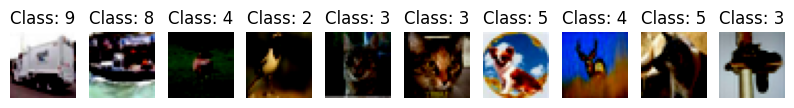

In [ ]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [ ]:
import torchvision.models as models
model = models.resnet34(pretrained = True) # Load ResNet34 model w/ pre-trained weight
print(model) # print the model architecture -- default ResNet34 model (pre-trained w/ Imagenet Dataset) has final 1000 output nodes
# BUT we have 10 classes in CIFAR"10" dataset!! What is CIFAR10?? Check https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html?highlight=cifar for details

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 101MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
## IMPORTANT: There are 2 ways to use pre-trained models

# (1) NOT updating the weights of the pre-trained models, and use the model as it is
for parameter in model.parameters():
    parameter.requires_grad = False # We previously learned the requires_grad means utilizing backpropagation

# (2) Updating the weights of the pre-trained mdoels
# for parameter in model.parameters():
#     parameter.requires_grad = True

# We usually use method #1 when using pre-trained models, but it's not the 100% perfect answer -- sometimes method #2 works better
# The optimal solution may vary according to the dataset or other techniques such as learning rate, optimizer, and so on

num_ftrs = model.fc.in_features # To mitigate such CIFAR"10" issue, we should add one more layer having final 10 output nodes
model.fc = nn.Linear(num_ftrs, 10) # Add such layer!

model = model.cuda()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.613104
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.869003
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.822994
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.618092
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.569185
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.559539
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.418813
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.515283

[EPOCH: 1], 	Test Loss: 1.6476, 	Test Accuracy: 45.22 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.387521
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.534919
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.444073
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.854538
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.518034
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.459462
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.371513
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.906988

[EPOCH: 2], 	Test Loss: 1.6593, 	Test Accuracy: 45.32 % 

### Question 1. Compare & Contrast the test result (accuracy) of requires_grad = False & True.


In [ ]:
model = models.resnet34(pretrained = True)

for parameter in model.parameters():
    parameter.requires_grad = True

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.687545
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.318762
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 0.877996
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.157517
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.279180
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.054381
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 0.956303
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 0.874430

[EPOCH: 1], 	Test Loss: 0.8327, 	Test Accuracy: 72.16 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 0.741374
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 0.709489
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 0.844847
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 0.771563
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 0.867101
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.307381
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 0.615220
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 0.675821

[EPOCH: 2], 	Test Loss: 0.8541, 	Test Accuracy: 70.39 % 

## 사전 학습된 모델의 파라미터를 업데이트 해주니 오히려 정확도가 올라갔다(?)

### Question 2. Change the model ResNet34 to ResNet50 and run the entire code. Compare & Contrast the results of those two models.


In [ ]:
model = models.resnet50(pretrained = True)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
for parameter in model.parameters():
    parameter.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.365686
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.596789
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.764448
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 2.055354
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.903934
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.425586
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.605333
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.436932

[EPOCH: 1], 	Test Loss: 1.5870, 	Test Accuracy: 47.97 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.385000
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.709693
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.399758
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.786387
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.242122
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.514364
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.253718
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.383077

[EPOCH: 2], 	Test Loss: 1.6766, 	Test Accuracy: 48.31 % 

## 작은 모델을 가지고 전이 학습을 했던 것보다는 성능이 높게 나오는 것을 확인할 수 있다.

### Question 3. Change the model ResNet34 to Inceptionv3 or v4 and run the entire code. Compare & Contrast the results of those two models.

In [ ]:
model = models.inception_v3(pretrained = True)
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
for parameter in model.parameters():
    parameter.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model = model.cuda()

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200) # 무엇이 문제인지는 알겠으나 어떻게 해결해야 할지 모르겠습니다ㅠㅠ
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

RuntimeError: Calculated padded input size per channel: (1 x 1). Kernel size: (3 x 3). Kernel size can't be greater than actual input size

### The End.

##### Please upload your Colab file @Github https://github.com/duneag2/intro-dl/tree/main/Assignment6

*   First, make your folder by your name (e.g. seungeun)
*   Then upload your "Jupyter Notebook" file under that directory

###### Need Help?



*   Please refer to this link https://yeko90.tistory.com/entry/%ED%8C%8C%EC%9D%B4%EC%8D%AC-colab%EC%BD%94%EB%9E%A9%EC%97%90%EC%84%9C-%EC%95%95%EC%B6%95%ED%8C%8C%EC%9D%BC-%ED%92%80%EA%B8%B0 OR
*   Just save your Jupyter Notebook (.ipynb) file in here (colab) and upload via 'Add file' - 'Upload files' https://nthree.tistory.com/60